In [1]:
import numpy as np
import matplotlib.pyplot as plt
from biaxread import *
from scipy.signal import medfilt
import matplotlib.patches as mpatches

%matplotlib inline

In [2]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def ReadExp(exp,path,disp_low,disp_high):
    data = ReadAscii('%s/%s/%s_data.txt'%(path,exp,exp))
    lower_row = find_nearest(np.ravel(data['LP_Disp']),disp_low)
    upper_row = find_nearest(np.ravel(data['LP_Disp']),disp_high)
    print lower_row,upper_row
    data = data[lower_row:upper_row]
    data['mu'] = data['mu'] - data['mu'][0]
    return data

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

def rslope(x,y,window):
    """
    Takes a data vector and a window to produce a vector of the running average slope.
    The window specifies the number of points on either side of the central point, so
    the total number of points in the slope fitting is 2*window+1.  Fitting is
    done by the least squares method where the slope is defined by the equation below.
    the beginning and ends are padded with NaN, so fewer points are in those slope
    estimates.  Addition and subtraction to the totals is used so that the sum is not
    recomputed each time, speeding the process.

                    sum(x)*sum(y)
        Sum(x*y) -  -------------
                          n
    m = -------------------------
                     (sum(x))^2
        sum(x^2) - --------------
                          n
    """

    import numpy as np

    # Check that x and y are the same length
    if len(x) != len(y):
        print "Error: x and y must be the same length"
        return 0

    N = len(x) # Number of points in the dataset
    slopes = np.ones(N) # Make array for slopes

    # Pad data with window number of points NaN on either side
    x_padded = np.empty(2*window+N)
    x_padded[0:window] = 0
    x_padded[window:N+window] = x
    x_padded[N+window:2*window+N] = 0

    y_padded = np.empty(2*window+N)
    y_padded[0:window] = 0
    y_padded[window:N+window] = y
    y_padded[N+window:2*window+N] = 0

    sum_x    = np.sum(x_padded[0:2*window+1])
    sum_y    = np.sum(y_padded[0:2*window+1])
    sum_x_sq = np.sum(x_padded[0:2*window+1]*x_padded[0:2*window+1])
    sum_xy   = np.sum(x_padded[0:2*window+1]*y_padded[0:2*window+1])

    n = np.empty(N)
    n[0:window] = np.arange(window+1,2*window+1)
    n[window:N-window] = window*2+1
    n[N-window:N] = np.arange(2*window,window,-1)

    slopes[0] = (sum_xy - (sum_x*sum_y/n[0]))/(sum_x_sq - (sum_x*sum_x/n[0]))

    for i in range(1,N):
        sum_x    = sum_x - x_padded[i-1] + x_padded[2*window+i]
        sum_y    = sum_y - y_padded[i-1] + y_padded[2*window+i]
        sum_x_sq = sum_x_sq - x_padded[i-1]*x_padded[i-1] + \
            x_padded[2*window+i]*x_padded[2*window+i]
        sum_xy   = sum_xy - x_padded[i-1]*y_padded[i-1] +\
            x_padded[2*window+i]*y_padded[2*window+i]
        slopes[i] = (sum_xy - (sum_x*sum_y/n[i]))/(sum_x_sq - (sum_x*sum_x/n[i]))
    return slopes

# Path to folders of biax data
data_path = '/Users/jleeman/Dropbox/PennState/BiaxExperiments'

# Make Nice Plot Colors
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format
# matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

#
# Read Data
#

path = '/Users/jleeman/Dropbox/PennState/BiaxExperiments'
dis_low = 30*1000
dis_high = 30.55*1000
p4343 = ReadExp('p4343',path,30041,dis_high)
p4345 = ReadExp('p4345',path,30034,dis_high)
p4347 = ReadExp('p4347',path,30016,dis_high)
p4342 = ReadExp('p4342',path,30031,dis_high)
p4351 = ReadExp('p4351',path,30049,dis_high)




Number of records: 5887623
Number of columns: 12


-------------------------------------------------
|           Name|           Unit|        Records|
-------------------------------------------------
|        row_num|            mic|        5887623|
|        LP_Disp|            MPa|        5887623|
|     Shr_stress|         micron|        5887623|
|       nor_disp|            MPa|        5887623|
|     Nor_stress|            sec|        5887623|
|           Time|         micron|        5887623|
|         OB_Top|         micron|        5887623|
|      OB_Bottom|         micron|        5887623|
|        OB_Diff|             Hz|        5887623|
|      Samp_Freq|              .|        5887623|
|             mu|         micron|        5887623|
-------------------------------------------------
3438660 3489576

Number of records: 6028557
Number of columns: 12


-------------------------------------------------
|           Name|           Unit|        Records|
------------------------------

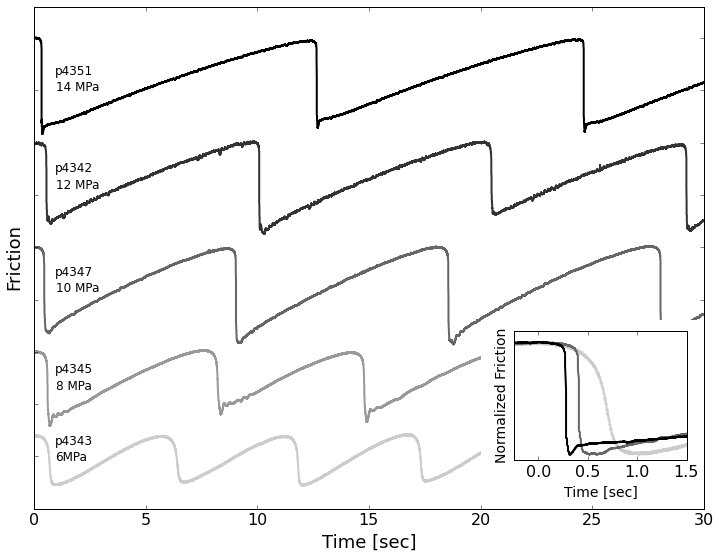

In [12]:
colors = [(255,150,150),(255,102,102),(255,51,51),(204,0,0), (153,0,0)]
colors = colors[::-1]

# Scale the RGB values to the [0, 1] range, which is the format
# matplotlib accepts.
for i in range(len(colors)):
    r, g, b = colors[i]
    colors[i] = (r / 255., g / 255., b / 255.)

colors = ['0.8','0.6','0.4','0.2','0']

vel_window = 11

# Setup figure and axes
# Generally plots is ~1.33x width to height (10,7.5 or 12,9)
fig = plt.figure(figsize=(12,9))
axA = plt.subplot(111)
# l,b,w,h
axC = plt.axes([0.68,0.2,0.2,0.2])
plt.subplots_adjust(wspace=0.31,hspace=0.35)
#axA = fig.add_subplot(2, 1, 1)
#axB = fig.add_subplot(2, 2, 3)
#axBv = axB.twinx()
#axC = fig.add_subplot(2, 2, 4)

#
# Plot A
#

# Set labels and tick sizes
axA.set_xlabel(r'Time [sec]',fontsize=18)
axA.set_ylabel(r'Friction',fontsize=18)
axA.tick_params(axis='both', which='major', labelsize=16)

# Turns off chart clutter

# Turn off top and right tick marks
#axA.get_xaxis().tick_bottom()
#axA.get_yaxis().tick_left()
axA.get_yaxis().set_ticks(np.arange(0,0.025*10,0.025))
axA.get_yaxis().set_ticklabels([])

# Turn off top and right splines
#axA.spines["top"].set_visible(False)
#axA.spines["right"].set_visible(False)

# Mask unload in p4338
# indices_to_mask = p4338['mu'] < -0.03
# p4338['mu'][indices_to_mask] = np.nan

# Plotting
window_size = 5
order = 3
axA.plot(p4343['Time']-p4343['Time'][0],np.ravel(p4343['mu'])+0.05*0.7,label='6 MPa',linewidth=2,color=colors[0])
axA.plot(p4345['Time']-p4345['Time'][0],np.ravel(p4345['mu'])+0.05*1.5,label='8 MPa',linewidth=2,color=colors[1])
axA.plot(p4347['Time']-p4347['Time'][0],np.ravel(p4347['mu'])+0.05*2.5,label='10 MPa',linewidth=2,color=colors[2])
axA.plot(p4342['Time']-p4342['Time'][0],np.ravel(p4342['mu'])+0.05*3.5,label='12 MPa',linewidth=2,color=colors[3])
axA.plot(p4351['Time']-p4351['Time'][0],np.ravel(p4351['mu'])+0.05*4.5,label='14 MPa',linewidth=2,color=colors[4])

x_pos = 24.85

# axA.text(x_pos,np.min(p4343['mu'])+0.05*0.9,r'$\sigma_n$ = 6 MPa',fontsize=12,color=tableau20[0])
# axA.text(x_pos,np.min(p4345['mu'])+0.05*1.9,r'$\sigma_n$ = 8 MPa',fontsize=12,color=tableau20[4])
# axA.text(x_pos,np.min(p4347['mu'])+0.05*3.05,r'$\sigma_n$ = 10 MPa',fontsize=12,color=tableau20[8])
# axA.text(x_pos,np.min(p4342['mu'])+0.05*4.,r'$\sigma_n$ = 12 MPa',fontsize=12,color=tableau20[12])
# axA.text(x_pos,np.min(p4351['mu'])+0.05*5.3,r'$\sigma_n$ = 14 MPa',fontsize=12,color=tableau20[18])
#
# axA.text(x_pos,np.min(p4343['mu'])+0.05*0.75,r'p4343',fontsize=10,color=tableau20[0])
# axA.text(x_pos,np.min(p4345['mu'])+0.05*1.75,r'p4345',fontsize=10,color=tableau20[4])
# axA.text(x_pos,np.min(p4347['mu'])+0.05*2.9,r'p4347',fontsize=10,color=tableau20[8])
# axA.text(x_pos,np.min(p4342['mu'])+0.05*3.85,r'p4342',fontsize=10,color=tableau20[12])
# axA.text(x_pos,np.min(p4351['mu'])+0.05*5.15,r'p4351',fontsize=10,color=tableau20[18])



# Set limits
axA.set_xlim(0,30)
axA.set_ylim(0,0.24)

#
# Plot C
#

# Set labels and tick sizes
axC.set_xlabel(r'Time [sec]',fontsize=14)
axC.set_ylabel(r'Normalized Friction',fontsize=14)
axC.tick_params(axis='both', which='major', labelsize=16)

# Turns off chart clutter

# Turn off top and right tick marks
#axC.get_xaxis().tick_bottom()
axC.get_yaxis().tick_left()
axC.get_yaxis().set_ticks([])

# Turn off top and right splines
#axC.spines["top"].set_visible(False)
#axC.spines["right"].set_visible(False)

# Plotting
start_row = 5096
end_row = 7096+500
#axC.plot(p4343['Time'][start_row:end_row]-p4343['Time'][start_row],p4343['mu'][start_row:end_row]+0.05*0.95,label='6 MPa',color=tableau20[0])

friction = p4343['mu'][start_row:end_row]
friction = friction - np.min(friction)
friction = friction/np.max(friction)
max_friction_idx = np.argmax(friction)
time = p4343['Time'][start_row:end_row]
time = time - time[max_friction_idx]
axC.plot(time,friction,label='6 MPa',color=colors[0],linewidth=2)

start_row = 7929
end_row = 9929+500
#axC.plot(p4347['Time'][start_row:end_row]-p4347['Time'][start_row],p4347['mu'][start_row:end_row]+0.05*0.95,label='10 MPa',color=tableau20[8])

friction = p4347['mu'][start_row:end_row]
friction = friction - np.min(friction)
friction = friction/np.max(friction)
max_friction_idx = np.argmax(friction)
time = p4347['Time'][start_row:end_row]
time = time - time[max_friction_idx]
axC.plot(time,friction,label='10 MPa',color=colors[2],linewidth=2)

start_row = 11398
end_row = 13398+500
#axC.plot(p4351['Time'][start_row:end_row]-p4351['Time'][start_row]-.18,p4351['mu'][start_row:end_row]+0.05*0.95,label='14 MPa',color=tableau20[18])

friction = p4351['mu'][start_row:end_row]
friction = friction - np.min(friction)
friction = friction/np.max(friction)
max_friction_idx = np.argmax(friction)
time = p4351['Time'][start_row:end_row]
time = time - time[max_friction_idx]
axC.plot(time,friction,label='14 MPa',color=colors[4],linewidth=2)

# Set limits
axC.set_xlim(-0.25,1.5)
axC.set_ylim(-0.05,1.1)

# White rectangle
rect = mpatches.Rectangle((20,0.005),10,0.085, ec="none",fc="white",zorder=10)
axA.add_patch(rect)

# Add Text Annotation
x_position = 0.15
font = 12
plt.figtext(x_position,0.2,'6MPa',fontsize=font,color='k')
plt.figtext(x_position,0.31,'8 MPa',fontsize=font,color='k')
plt.figtext(x_position,0.46,'10 MPa',fontsize=font,color='k')
plt.figtext(x_position,0.62,'12 MPa',fontsize=font,color='k')
plt.figtext(x_position,0.77,'14 MPa',fontsize=font,color='k')

y_offset = 0.025
plt.figtext(x_position,0.2+y_offset,'p4343',fontsize=font,color='k')
plt.figtext(x_position,0.31+y_offset,'p4345',fontsize=font,color='k')
plt.figtext(x_position,0.46+y_offset,'p4347',fontsize=font,color='k')
plt.figtext(x_position,0.62+y_offset,'p4342',fontsize=font,color='k')
plt.figtext(x_position,0.77+y_offset,'p4351',fontsize=font,color='k')

# Scale Bar
#x_pos = 27
#axA.plot([x_pos,x_pos],[0.005,0.005+0.0242],color='k',linewidth=2)
#axA.text(x_pos-2.3,0.015,r'0.025 $\mu$',fontsize=12,color='k')

plt.savefig('events.pdf', bbox_inches="tight")
#plt.show()
